In [12]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["SM_FRAMEWORK"] = "tf.keras"
import tensorflow as tf
from tensorflow import keras
import segmentation_models as sm
import cv2
import numpy as np

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
classes = ["Real", "Deepfake"]
SIZE = (112, 112)
CHANNELS = 3
NBFRAME = 90

In [4]:
input_shape = SIZE + (CHANNELS,)

In [6]:
model = keras.models.load_model("video_model.h5", compile=False)

In [7]:
model.load_weights("Weights/model_weights")

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 90, 32)            17040     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 90, 32)            0         
_________________________________________________________________
gru (GRU)                    (None, 256)               222720    
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 256,338
Trainable params: 256,146
Non-trainable params: 192
______________________________________________

In [9]:
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from tensorflow.python.keras.utils.vis_utils import plot_model

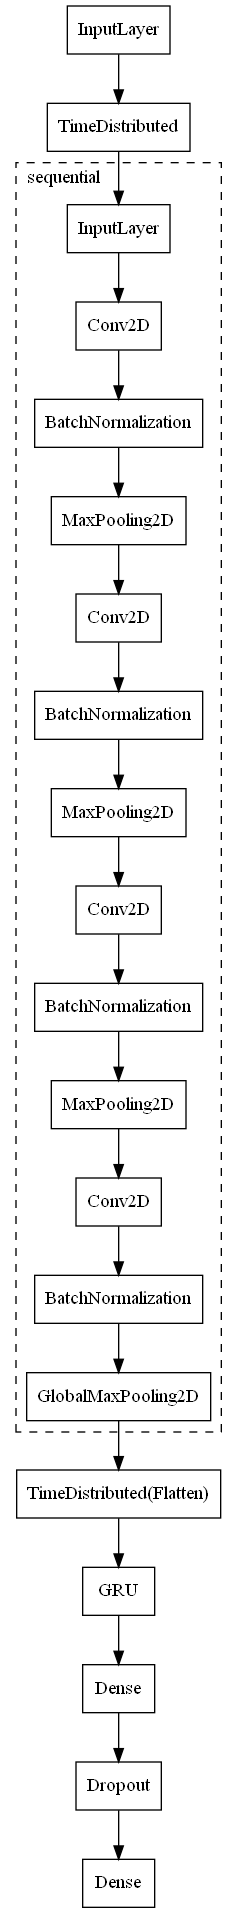

In [10]:
plot_model(
    model, to_file='model.png',
    show_layer_names=False, rankdir='TB', expand_nested=True)

In [15]:
def predict(path):
    cap = cv2.VideoCapture(path)
    img_array = []
    success = 1
    i = 1
    faceCascade = cv2.CascadeClassifier("Resources/haarcascade_frontalface_default.xml")

    while success and i <= 90:
        success, img = cap.read()
        try:
            imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            faces = faceCascade.detectMultiScale(imgGray, 1.1, 4)
            if np.shape(faces) == (1, 4):
                x, y, w, h = faces[0]
                imgCropped = img[y: y + h, x:x + w]
                imgCropped = cv2.resize(imgCropped, (112, 112))
                img_array.append(imgCropped)
                i += 1
        except:
            return "Provide a video with more than 90 frames"

    img_array = np.array(img_array)
    img_array = img_array.reshape(1, 90, 112, 112, 3)

    res = model.predict(img_array).round()
    if res[0][0] == 0:
        return "Real"
    else:
        return "Deepfake"

In [17]:
predict("Test/WIN_20220412_00_53_12_Pro.mp4")

'Real'